# Trial Run for the BranchPro module using Synthetic Data

In order to assess how well the functionalities implemented in the ``branchpro`` module cope with realistic data, we will first generate some artificial incidence cases using a reasonable instance of an R profile.


In [1]:
# Import requirements
import branchpro

import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import plotly.graph_objects as go

## Set true R profile

In [2]:
# Read the reproduction number values
new_rs = [3, 2.7, 2.5, 2.4, 2.3, 2.2, 1.9, 1.8, 1.9, 1.7, 1.6, 1.3, 1.3, 1.2, 1.1, 0.9, 1, 1.1, 0.95, 0.9, 0.8, 0.7, 0.75, 0.8, 0.77, 0.73, 0.7, 0.68, 0.65, 0.67, 0.66, 0.72]

# Construct vector of the times at which each of the R number changes occur
start_times = np.arange(1, len(new_rs)+1, dtype=int)

## Generate Incidence Data

Using this realistically behaved reproduction numbers, we will use the forward simulation functionality to sample incidence data which we will use in the following steps to do inference and try to reconstruct the true R profile underlining the data.

### Set evaluation times and serial interval distribution

We wish to obtain data for all the time points for which we know the value of the *reproduction number*. We also assume that the *serial interval* is shaped similarly to a gamma distribution, which we will in turn discretize to fit the way the *forward simulation* works.

In [3]:
# Take evaluation times for the forward simulation as the times corresponding to the R profile
times = np.arange(len(new_rs)+1)

# Build the serial interval w_s
num_timepoints = len(new_rs)
ws_mean = 2.6
ws_var = 1.5**2
theta = ws_var / ws_mean
k = ws_mean / theta
 
w_dist = scipy.stats.gamma(k, scale=theta)
disc_w = w_dist.pdf(np.arange(num_timepoints))

We assume that the imported cases are sampled from a zero-inflated poisson with given mean $\lambda$ and weight $\pi$. For this we will cosntruct first a function to sample observations from such a distribution.

In [4]:
# Construct a zero-inflated poisson sampler
def zero_inf_poss_sampler(pi, mean, num_samples=1):
    # First check if we sample from the Poisson or Dirac centred at the origin distribution
    unif_samples = scipy.stats.uniform.rvs(size=num_samples)
    sample = np.zeros_like(unif_samples)

    for s in range(num_samples):
        # If we fall out of the Dirac category, we sample from Poisson
        if unif_samples[s] > pi:
            sample[s] = scipy.stats.poisson.rvs(mean)
    
    return sample

### Imported cases

In [5]:
# Build the imported cases
pi = 0.6
ic_mean = 25
imported_times = np.arange(1,(num_timepoints+1))

imported_cases = zero_inf_poss_sampler(pi=pi, mean=ic_mean, num_samples=num_timepoints)

### Locally produced cases

Assume for this data a constant of proportionality of $1+\epsilon$ between the reproduction number of the imported cases and those produced locally, as per the formula:

$$
R_{t}^{\text{imported}} = (1 + \epsilon)R_{t}^{\text{local}}
$$

In [6]:
# Construct LocImpBranchProModel object
epsilon = 1.5

initial_r = 3
serial_interval = disc_w
m = branchpro.LocImpBranchProModel(initial_r, serial_interval, epsilon)

m.set_r_profile(new_rs, start_times)

parameters = 10 # initial number of cases

m.set_imported_cases(imported_times, imported_cases)
locally_infected_cases = m.simulate(parameters, times)

### Plot the local and imported cases as a bar chart for visual comparison 

In [7]:
# Plot (bar chart cases each day)
fig = go.Figure()

# Plot of incidences
fig.add_trace(
    go.Bar(
        x=times,
        y=locally_infected_cases,
        name='Local Incidences'
    )
)

fig.add_trace(
    go.Bar(
        x=start_times,
        y=imported_cases,
        name='Imported Cases'
    )
)

# Add axis labels
fig.update_layout(
    xaxis_title='Time (days)',
    yaxis_title='New cases'
)

fig.show()


We now pack this data in a ``.csv`` file to be included in the data_library

In [8]:
# Initialise a dictionary for the data
data_to_pack = {}

data_to_pack['Time'] = start_times
data_to_pack['Incidence Number'] = locally_infected_cases[1:]
data_to_pack['Imported Cases'] = imported_cases
data_to_pack['R_t'] = new_rs

data_to_pack = pd.DataFrame.from_dict(data_to_pack)

In [9]:
data_to_pack.to_csv('../data_library/synthetic_data_InInc10_Eps1-5_ImpMean_25.csv', index=False)

We create slider for the $\epsilon$ parameter so we can see how continuous changes in its value impact the number of local incidences even when keeping the imported ones as previously

In [10]:
# Slider (epsilon)
fig = go.Figure()

# Add traces, one for each slider step
for epsilon in np.arange(-0.99, 2, 0.01):
    m.set_r_profile(new_rs, start_times)
    m.set_epsilon(epsilon)

    cases = m.simulate(parameters, times)
    
    fig.add_trace(
        go.Bar(
            x=times,
            y=cases,
            name='Local Incidences'
        ))
    

    fig.add_trace(
        go.Bar(
            x=start_times,
            y=imported_cases,
            name='Imported Cases'
        ))

#         go.Scatter(
#             visible=False,
#             line=dict(color="#00CED1", width=6),
#             name="𝜈 = " + str(step),
#             x=np.arange(0, 10, 0.01),
#             y=np.sin(step * np.arange(0, 10, 0.01)))

# Make 10th trace visible
fig.data[10].visible = True

# Create and add slider
steps = []
for i in range(int(len(fig.data)/2)):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)},
              {"title": "Slider switched to step: " + str(i)}],  # layout attribute
    )
    step["args"][0]["visible"][2*i] = True  # Toggle i'th trace to "visible"
    step["args"][0]["visible"][2*i+1] = True
    steps.append(step)

sliders = [dict(
    active=10,
    currentvalue={"prefix": "Frequency: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    sliders=sliders
)

# Add axis labels
fig.update_layout(
    xaxis_title='Time (days)',
    yaxis_title='New local cases'
)

fig.show()

## Implement Inference

Using the functionality of the ``branchpro`` module, we infer the R profile of the local and imported cases for the correct value of $\epsilon = 0$.

In [11]:
# Same inference, but using the LocImpBranchProPosterior
tau = 2
R_t_start = tau+1
a = 1
b = 0.8

# Transform our incidence data into pandas dataframes
inc_data = pd.DataFrame(
    {
        'Time': times,
        'Incidence Number': locally_infected_cases
    }
)

imported_inc_data = pd.DataFrame(
    {
        'Time': start_times,
        'Incidence Number': imported_cases
    }
)

inference = branchpro.LocImpBranchProPosterior(
    inc_data=inc_data,
    imported_inc_data=imported_inc_data,
    epsilon=epsilon,
    daily_serial_interval=serial_interval,
    alpha=a,
    beta=1/b)

inference.run_inference(tau=tau)
intervals = inference.get_intervals(central_prob=.95)

### Plot true versus infered R profiles

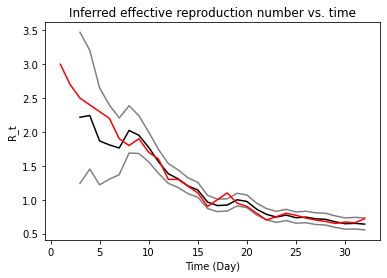

In [12]:
fig = plt.figure()
plt.plot(start_times[R_t_start-1:], intervals['Mean'], 'k')
plt.plot(start_times[R_t_start-1:], intervals['Lower bound CI'], 'gray')
plt.plot(start_times[R_t_start-1:], intervals['Upper bound CI'], 'gray')
plt.plot(start_times, new_rs, 'red')
plt.xlabel('Time (Day)')
plt.ylabel('R_t')
plt.title('Inferred effective reproduction number vs. time')

plt.show()